In [1]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns

from sklearn.utils import resample

from aif360.datasets import BinaryLabelDataset
from aif360.datasets import GermanDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.explainers import MetricTextExplainer, MetricJSONExplainer
from aif360.algorithms.preprocessing.reweighing import Reweighing

import json

from sklearn.preprocessing import StandardScaler, scale
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score

from IPython.display import Markdown, display
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[LFR]'


<a id='main'></a>

### Steps in the Data Science Pipeline

1. [Data Preparation](#data_prep)  
2. Bias Detection and Mitigation  
    a. [Bias Detection](#find_bias)  
    b. [Bias Mitigation](#fix_bias)  
3. [Modelling](#data_model)  
4. [Tradeoffs](#tradeoffs)

<a id='data_prep'></a>

### 1. Data Preparation

In [27]:
orig_dataset = GermanDataset(protected_attribute_names=['sex', 'age'])

In [28]:
# fix labels to be 0s and 1s
# originally, 2 = bad credit, 1 = good credit
orig_dataset.labels = np.where(orig_dataset.labels == 2, 0, 1)

In [29]:
orig_dataset.unfavorable_label = 0.0

In [30]:
orig_dataset.metadata['protected_attribute_maps']

[{1.0: 'Male', 0.0: 'Female'}, {1.0: 'Old', 0.0: 'Young'}]

In [31]:
# check distribution of classes
df_og = orig_dataset.convert_to_dataframe()[0]
df_og['credit'].value_counts()

1.0    700
0.0    300
Name: credit, dtype: int64

<a id='find_bias'></a>

#### Drop redundant variables

In [32]:
df_og = df_og[['credit', 'month', 'credit_amount', 'investment_as_income_percentage', 'residence_since', 'age',
               'number_of_credits', 'people_liable_for', 'sex',
               # dropped status=A14
               'status=A11', 'status=A12', 'status=A13',
               # dropped credit_history=A30
               'credit_history=A31', 'credit_history=A32', 'credit_history=A33', 'credit_history=A34',
               # dropped purpose=A410
               'purpose=A40', 'purpose=A41', 'purpose=A42', 'purpose=A43', 'purpose=A44', 'purpose=A45', 'purpose=A46', 'purpose=A48', 'purpose=A49', 
               # dropped savings=A65
               'savings=A61', 'savings=A62', 'savings=A63', 'savings=A64', 
               # dropped employment=A71
               'employment=A72', 'employment=A73', 'employment=A74', 'employment=A75',
               # dropped other_debtors=A101
               'other_debtors=A102', 'other_debtors=A103',
               # dropped property=A124
               'property=A121', 'property=A122', 'property=A123',
               # dropped installment_pans=A143
               'installment_plans=A141', 'installment_plans=A142',
               # dropped housing=A152
               'housing=A151', 'housing=A153',
               # dropped skill_level=A174
               'skill_level=A171', 'skill_level=A172', 'skill_level=A173',
               # dropped telephone=A191
               'telephone=A192',
               # dropped foreign_workers=A202
               'foreign_worker=A201'
            ]].copy()

In [33]:
orig_dataset = BinaryLabelDataset(df=df_og, label_names=['credit'], protected_attribute_names=['sex', 'age'],
                                  favorable_label=1.0, unfavorable_label=0.0)

In [36]:
display(Markdown("#### Original Dataset shape"))
print(orig_dataset.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(orig_dataset.favorable_label, orig_dataset.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(orig_dataset.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(orig_dataset.privileged_protected_attributes, 
      orig_dataset.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(orig_dataset.feature_names)

#### Original Dataset shape

(1000, 46)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['sex', 'age']


#### Privileged and unprivileged protected attribute values

[array([1.]), array([1.])] [array([0.]), array([0.])]


#### Dataset feature names

['month', 'credit_amount', 'investment_as_income_percentage', 'residence_since', 'age', 'number_of_credits', 'people_liable_for', 'sex', 'status=A11', 'status=A12', 'status=A13', 'credit_history=A31', 'credit_history=A32', 'credit_history=A33', 'credit_history=A34', 'purpose=A40', 'purpose=A41', 'purpose=A42', 'purpose=A43', 'purpose=A44', 'purpose=A45', 'purpose=A46', 'purpose=A48', 'purpose=A49', 'savings=A61', 'savings=A62', 'savings=A63', 'savings=A64', 'employment=A72', 'employment=A73', 'employment=A74', 'employment=A75', 'other_debtors=A102', 'other_debtors=A103', 'property=A121', 'property=A122', 'property=A123', 'installment_plans=A141', 'installment_plans=A142', 'housing=A151', 'housing=A153', 'skill_level=A171', 'skill_level=A172', 'skill_level=A173', 'telephone=A192', 'foreign_worker=A201']


[Go to top](#main)

### 2. Bias Detection and Mitigation

### 2a. Bias Detection

In [38]:
def make_results_table(results, list_of_vars):

    def expand_metric(df, metric, list_of_vars):
        # expand dictionary column into dataframe
        df = df[metric].apply(pd.Series)
        df['name'] = list_of_vars
        # get metric value
        df['message'] = df['message'].astype(str)
        df[metric] = df['message'].apply(lambda x: x.split(':')[1])
        # keep relevant columns
        df = df[['name', metric]].copy()
        df[metric] = df[metric].astype(float).round(2)
        return df
    
    # convert json into dataframe
    df_results = pd.DataFrame.from_dict(results, orient='index').reset_index().rename(columns={'index':'Feature', 
                                                                                               0:'Mean Difference',
                                                                                               1: 'Disparate Impact',
                                                                                               2: 'Consistency'})
    # get column names
    list_of_metrics = df_results.columns[1:].tolist()
    df0 = pd.DataFrame(np.zeros((len(list_of_vars), 1)))
    
    for metric in list_of_metrics:
        df = expand_metric(df_results, metric, list_of_vars)
        df0 = pd.concat([df0,df], axis=1)
    
    # get variable names
    vars_col = df0['name'].iloc[:,0]
    df0.drop(columns=['name', 0], inplace=True)
    df0['Name'] = vars_col
    df0 = df0[['Name', 'Mean Difference', 'Disparate Impact', 'Consistency']].copy()
    return df0


def get_fairness_metrics(dataset):
    # NOTE: dataset expected to a BinaryLabelDataset
    results = {}
    list_of_vars = []
    
    for var in dataset.protected_attribute_names:
        privileged_groups = []
        unprivileged_groups = []

        privileged_groups.append({var: 0})
        unprivileged_groups.append({var: 1})

        metrics = BinaryLabelDatasetMetric(dataset,
                                           unprivileged_groups=unprivileged_groups,
                                           privileged_groups=privileged_groups)


        json_explainer = MetricJSONExplainer(metrics)
        
        mean_diff = json.loads(json_explainer.mean_difference())
        di = json.loads(json_explainer.disparate_impact())
        # NOTE: json_explainer.consistency() has a bug (https://github.com/Trusted-AI/AIF360/issues/227)
        consist = metrics.consistency(n_neighbors=5)[0]
        # create array to manage around bug in source code
        consist_d = {'metric': 'Consistency',
                     'message': 'Consistency (measures how similar labels are for similar instances): '+str(consist)}

        results[var] = [mean_diff, di, consist_d]
        list_of_vars.append(var)
        
    df = make_results_table(results, list_of_vars)
    return df

#### Get baseline for each protected attribute

In [39]:
get_fairness_metrics(orig_dataset)

,Name,Mean Difference,Disparate Impact,Consistency
0,sex,0.07,1.12,0.68
1,age,0.15,1.26,0.68


<a id='fix_bias'></a>

[Go to top](#main)

### 2b. Bias Mitigation

In [40]:
def reweigh_dataset(privileged_groups, unprivileged_groups, dataset):
    # NOTE: dataset expected to be a BinaryLabelDataset
    privileged_groups = privileged_groups
    unprivileged_groups = unprivileged_groups

    # reweigh training dataset
    RW = Reweighing(unprivileged_groups=unprivileged_groups,
                    privileged_groups=privileged_groups)

    RW.fit(dataset)
    dataset_transformed = RW.transform(dataset)
    
    diff = dataset_transformed.instance_weights.sum() - dataset.instance_weights.sum()
    print("The difference in weights between original and transformed dataset is %s" % diff)
    
    return dataset_transformed

In [41]:
# old is privileged, young is unprivileged
privileged_groups = [{'age': 1}]
unprivileged_groups = [{'age': 0}]

In [42]:
dataset_og_rw1 = reweigh_dataset(privileged_groups, unprivileged_groups, orig_dataset)

The difference in weights between original and transformed dataset is 0.0


In [43]:
get_fairness_metrics(dataset_og_rw1)

,Name,Mean Difference,Disparate Impact,Consistency
0,sex,0.04,1.06,0.68
1,age,-0.00,1.00,0.68


In [44]:
# male is privileged, female is unprivileged
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

In [45]:
dataset_og_rw2 = reweigh_dataset(privileged_groups, unprivileged_groups, dataset_og_rw1)

The difference in weights between original and transformed dataset is -2.2737367544323206e-13


In [46]:
get_fairness_metrics(dataset_og_rw2)

,Name,Mean Difference,Disparate Impact,Consistency
0,sex,-0.00,1.00,0.68
1,age,-0.01,0.98,0.68


<a id='data_model'></a>

In [47]:
dataset_transf = dataset_og_rw2.copy()

[Go to top](#main)

### 3. Modelling

In [48]:
# 70:30 split into train, test
dataset_train, dataset_test = orig_dataset.split([0.7], shuffle=True)

In [49]:
# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(dataset_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_train.favorable_label, dataset_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_train.privileged_protected_attributes, 
      dataset_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_train.feature_names)

#### Training Dataset shape

(700, 46)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['sex', 'age']


#### Privileged and unprivileged protected attribute values

[array([1.]), array([1.])] [array([0.]), array([0.])]


#### Dataset feature names

['month', 'credit_amount', 'investment_as_income_percentage', 'residence_since', 'age', 'number_of_credits', 'people_liable_for', 'sex', 'status=A11', 'status=A12', 'status=A13', 'credit_history=A31', 'credit_history=A32', 'credit_history=A33', 'credit_history=A34', 'purpose=A40', 'purpose=A41', 'purpose=A42', 'purpose=A43', 'purpose=A44', 'purpose=A45', 'purpose=A46', 'purpose=A48', 'purpose=A49', 'savings=A61', 'savings=A62', 'savings=A63', 'savings=A64', 'employment=A72', 'employment=A73', 'employment=A74', 'employment=A75', 'other_debtors=A102', 'other_debtors=A103', 'property=A121', 'property=A122', 'property=A123', 'installment_plans=A141', 'installment_plans=A142', 'housing=A151', 'housing=A153', 'skill_level=A171', 'skill_level=A172', 'skill_level=A173', 'telephone=A192', 'foreign_worker=A201']


### Logistic Regression

#### Train

In [50]:
scale_orig = StandardScaler()

# scale values, setup training data
X_train = scale_orig.fit_transform(dataset_train.features)
y_train = dataset_train.labels.ravel()
w_train = dataset_train.instance_weights.ravel()

# train logistic model
logreg = LogisticRegression().fit(X_train, y_train, sample_weight=w_train)
y_train_pred = logreg.predict(X_train) #this seems wrong

In [51]:
# dataset_train --> dataset_train_pred
dataset_train_pred = dataset_train.copy()
dataset_train_pred.labels = y_train_pred

In [52]:
# accuracy score
(y_train_pred == y_train).sum()/len(y_train)

0.8028571428571428

In [53]:
def find_metrics(labels, preds, thresh=None, print_results=True):
    if thresh == None:
        thresh = np.mean(labels)
    
    y_preds = np.where(preds > thresh, 1, 0)
    
    bal_acc = balanced_accuracy_score(labels, y_preds)
    acc = accuracy_score(labels, y_preds)
    prec_score = precision_score(labels, y_preds)
    rec_score = recall_score(labels, y_preds)
    
    if print_results:
        print("The mean threshold of the model is %f " % (thresh))
        print("The accuracy score of the model is %s" % acc)
        print("The balanced accuracy score of the model is %s" % bal_acc)
        print("Precision: %s" % prec_score)
        print("Recall: %s" % rec_score)
    
    return bal_acc, thresh

#### Test

In [54]:
# dataset_test --> dataset_test_pred
dataset_test_pred = dataset_test.copy(deepcopy=True)
X_test = scale_orig.transform(dataset_test_pred.features)
y_test = dataset_test_pred.labels

# get preds for obs being in risk group 1
pos_ind = 1
dataset_test_pred.scores = logreg.predict_proba(X_test)[:,pos_ind].reshape(-1,1)
y_test_pred = dataset_test_pred.scores

In [55]:
find_metrics(y_test, y_test_pred)

The mean threshold of the model is 0.743333 
The accuracy score of the model is 0.64
The balanced accuracy score of the model is 0.6388096208724011
Precision: 0.8362573099415205
Recall: 0.6412556053811659


(0.6388096208724011, 0.7433333333333333)

#### Find optimal classification threshold for logistic model

#### Test dataset

In [56]:
privileged_groups = [{'sex': 1, 'age': 1}]
unprivileged_groups = [{'sex': 0, 'age': 0}]

# select datasets
d1 = dataset_test
d2 = dataset_test_pred

In [57]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
thresh_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)

for idx, class_thresh in enumerate(class_thresh_arr):
    # labels = y_test, scores = y_preds
    fav_inds = d2.scores > class_thresh
    d2.labels[fav_inds] = d2.favorable_label
    d2.labels[~fav_inds] = d2.unfavorable_label

    metrics_valid = ClassificationMetric(d1, d2, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)

    thresh_arr[idx] = class_thresh
    ba_arr[idx] = 0.5*(metrics_valid.true_positive_rate()+metrics_valid.true_negative_rate())
    
# best threshold is where accuracy is max
best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_bal_acc = np.max(ba_arr)
best_class_thresh = class_thresh_arr[best_ind]

print("Optimal threshold without reweighing")
print("------------------------------------------")
print("Best balanced accuracy = %.6f" % np.max(ba_arr))
print("Optimal classification threshold = %.4f" % best_class_thresh)

Optimal threshold without reweighing
------------------------------------------
Best balanced accuracy = 0.664696
Optimal classification threshold = 0.8514


#### Train on transformed data

In [58]:
# 70:30 split into train, test
dataset_transf_train, dataset_transf_test = dataset_transf.split([0.7], shuffle=True)

#### Train

In [59]:
scale_transf = StandardScaler()
X_train_transf = scale_transf.fit_transform(dataset_transf_train.features)
y_train_transf = dataset_transf_train.labels.ravel()
w_train_transf = dataset_transf_train.instance_weights.ravel()

logreg = LogisticRegression().fit(X_train_transf, y_train_transf, sample_weight=w_train_transf)
y_train_pred = logreg.predict(X_train_transf)

#### Test

In [60]:
dataset_transf_test_pred = dataset_transf_test.copy(deepcopy=True)

X_test_transf = scale_transf.fit_transform(dataset_transf_test_pred.features)
y_test_transf = dataset_transf_test_pred.labels

# prob of predicting obs to be in risk group 1
pos_ind = 1
dataset_transf_test_pred.scores = logreg.predict_proba(X_test_transf)[:,pos_ind].reshape(-1,1)
y_test_preds_transf = dataset_transf_test_pred.scores

In [61]:
find_metrics(y_test_transf, y_test_preds_transf)

The mean threshold of the model is 0.700000 
The accuracy score of the model is 0.7
The balanced accuracy score of the model is 0.6841269841269841
Precision: 0.8260869565217391
Recall: 0.7238095238095238


(0.6841269841269841, 0.7)

<a id='tradeoffs'></a>

[Go to top](#main)

### 4. Tradeoffs

In [62]:
d1 = dataset_test
d2 = dataset_test_pred

In [63]:
display(Markdown("#### Predictions from original testing data"))
bal_acc_arr = []
mean_diff_arr = []
disp_imp_arr = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = d2.scores > thresh
    d2.labels[fav_inds] = d2.favorable_label
    d2.labels[~fav_inds] = d2.unfavorable_label
    
    metrics_test = ClassificationMetric(d1, d2,
                                        unprivileged_groups=unprivileged_groups,
                                        privileged_groups=privileged_groups)
    
    bal_acc = 0.5*(metrics_test.true_positive_rate()+metrics_test.true_negative_rate())
    bal_acc_arr.append(bal_acc)
    
    mean_diff_arr.append(metrics_test.mean_difference())    
    disp_imp_arr.append(metrics_test.disparate_impact())

#### Predictions from original testing data

100%|██████████| 100/100 [00:00<00:00, 896.34it/s]

Classification threshold used = 0.8514


#### Transformed dataset

In [64]:
# select datasets
d1 = dataset_transf_test
d2 = dataset_transf_test_pred

In [65]:
display(Markdown("#### Predictions from transformed testing data"))
bal_acc_arr_transf = []
mean_diff_arr_transf = []
disp_imp_arr_transf = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_transf_test_pred.scores > thresh
        
    # broadcast labels
    d2.labels[fav_inds] = d2.favorable_label
    d2.labels[~fav_inds] = d2.unfavorable_label
    
    metrics_test_transf = ClassificationMetric(d1, d2, 
                                               unprivileged_groups=unprivileged_groups,
                                               privileged_groups=privileged_groups)

    bal_acc = 0.5*(metrics_test_transf.true_positive_rate()+metrics_test_transf.true_negative_rate())
    bal_acc_arr_transf.append(bal_acc)

    mean_diff_arr_transf.append(metrics_test_transf.mean_difference())
    disp_imp_arr_transf.append(metrics_test_transf.disparate_impact())

#### Predictions from transformed testing data

100%|██████████| 100/100 [00:00<00:00, 977.32it/s]

Classification threshold used = 0.8514


#### Visualize tradeoffs

In [66]:
sns.set()

In [67]:
# find points to annotate
best_bal_acc = np.max(bal_acc_arr)
best_class_thresh = class_thresh_arr[np.where(bal_acc_arr == best_bal_acc)[0][0]]

In [68]:
best_mean_diff = mean_diff_arr[np.where(class_thresh_arr == np.float64(best_class_thresh))[0][0]]



In [69]:
best_mean_diff_transf = mean_diff_arr_transf[np.where(class_thresh_arr == np.float64(best_class_thresh))[0][0]]



In [70]:
def plot_tradeoffs(thresholds_array, accuracy_array, fairness_array, transformed_fairness_array, ax, name):
    ax.plot(thresholds_array, accuracy_array)
    ax.set_xlabel('Classification Thresholds', fontsize=10.5)
    ax.set_ylabel('Balanced Accuracy', color='b', fontsize=12, labelpad=15)
    # best_class_thresh used as global variable
    ax.axvline(best_class_thresh, color='k', linestyle=':')

    ax1 = ax.twinx()
    ax1.plot(thresholds_array, fairness_array, color='r', alpha=0.5)
    ax1.set_ylabel(name, color='r', fontsize=12, rotation=-90, labelpad=15)
    ax1.plot(thresholds_array, transformed_fairness_array, color='r')
    
    ax.set_title(name, fontsize=16)
    ax1.legend(['Original', 'Transformed'], loc='lower left')
    ax1.grid(True)

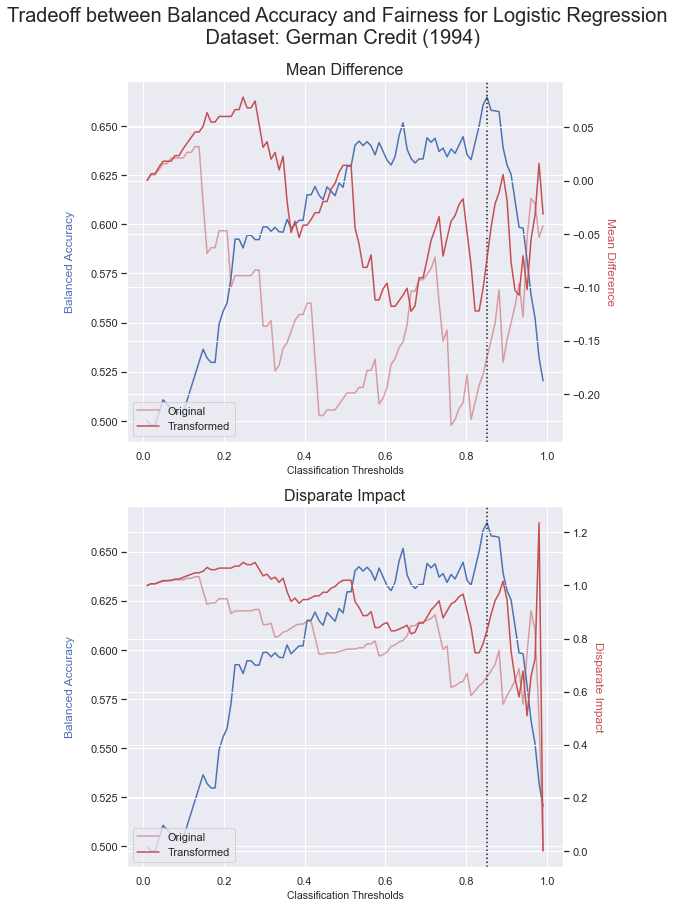

In [71]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(8,12))

plot_tradeoffs(class_thresh_arr, bal_acc_arr, mean_diff_arr, mean_diff_arr_transf, ax=ax[0], name='Mean Difference')

plot_tradeoffs(class_thresh_arr, bal_acc_arr, disp_imp_arr, disp_imp_arr_transf, ax=ax[1], name='Disparate Impact')

# for ax in fig.get_axes():
#     ax.label_outer()

fig.tight_layout()
# fig.subplots_adjust(hspace=0.25)
fig.suptitle('Tradeoff between Balanced Accuracy and Fairness for Logistic Regression \n Dataset: German Credit (1994)', 
             x=0.5, y=1.05, size=20)
plt.show()

[Go to top](#main)